In [1]:
%matplotlib inline

from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pylab
from scipy import stats, integrate
plt.style.use('ggplot')

In [2]:
import seaborn as sns
sns.set(color_codes=True)

In [3]:
np.random.seed(sum(map(ord, "distributions")))

In [4]:
df = pd.read_csv("LTV.csv", header=0, parse_dates=['date'], names=['id', 'store_id', 
                                                                   'date', 'channel',
                                                                   'substore', 'revenue',
                                                                   'profit'])
df['date'] = pd.to_datetime(df['date'])
df['channel'] = df['channel'].astype("category")
df['substore'] = df['substore'].astype("category")
#df['id'] = df['id'].astype("category")
del df['store_id']
df.sort_values(by="id")
#df.set_index('date', inplace=True)
df = pd.concat([store.loc[store.duplicated(subset='id', keep=False), :] for name, store in df.groupby('substore')])
df['substore'] = df['substore'].cat.remove_unused_categories()
#df['id'] = df['id'].cat.remove_unused_categories()
df['channel'] = df['channel'].cat.remove_unused_categories()

In [5]:
by_store = df.groupby('substore')

In [58]:
garmin = df[df['substore'] == 'Garmin']
panasonic = df[df['substore'] == 'Panasonic'] 
norelco = df[df['substore'] == 'Norelco'] 
stores = [garmin, panasonic, norelco]
#set(df['substore'].values)
#garmin.head(5)

In [7]:
num_customers = pd.Series([len(x.id.value_counts()) for x in stores], ['Garmin', 'Panasonic', 'Norelco'])
num_customers

Garmin       62548
Panasonic    18404
Norelco      32156
dtype: int64

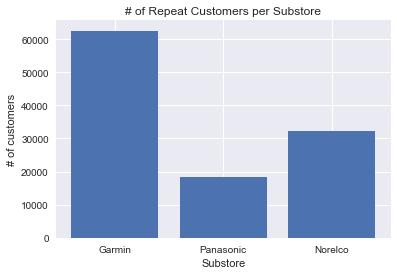

In [8]:
ind = np.arange(3)
plt.bar(ind, num_customers)

plt.xlabel("Substore")
plt.title('# of Repeat Customers per Substore')
plt.ylabel("# of customers")
plt.xticks(ind , num_customers.keys())
plt.show()

In [9]:
order_size = pd.DataFrame([[np.mean(store.revenue), np.mean(store.profit)] for store in stores],
                       index=['Garmin', 'Panasonic', 'Norelco'], columns=["Revenue", "Profit"])
order_size

,Revenue,Profit
Garmin,141.249229,31.050787
Panasonic,87.489050,26.283024
Norelco,65.146540,21.464880


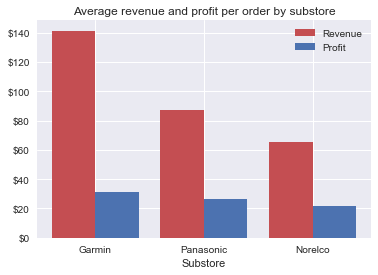

In [10]:
ind = np.arange(3)
width = .4

fig, ax = plt.subplots()
rects1 = ax.bar(ind, order_size['Revenue'].values, width, color='r')

rects2 = ax.bar(ind+width, order_size.Profit.values, width, color='b')

ax.set_xlabel("Substore")
ax.set_title('Average revenue and profit per order by substore')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(order_size.axes[0])
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)

ax.legend((rects1[0], rects2[0]), ('Revenue', 'Profit'), loc=0)

In [11]:
by_id = [x.groupby('id') for x in stores]
order_intervals = []
for store in by_id:
    
    intervals = []
    
    for name, group in store:
        dates = sorted(list(group['date']))
        intervals.append([(j-i).days for i, j in zip(dates[:-1], dates[1:])])
    
    order_intervals.append(intervals)

In [12]:
avg_intervals = [np.mean([np.mean(x) for x in y]) for y in order_intervals]
avg_intervals

[310.66023028640171, 348.97632198694629, 455.63433504122509]

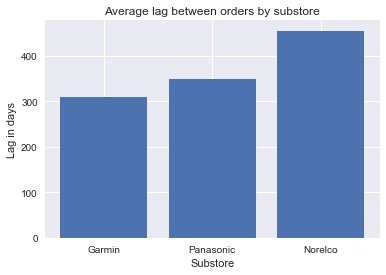

In [13]:
ind = np.arange(3)
plt.bar(ind, avg_intervals)

plt.xlabel("Substore")
plt.title('Average lag between orders by substore')
plt.ylabel("Lag in days")
plt.xticks(ind , num_customers.keys())
plt.show()

In [14]:
total_lifespan = [np.mean([np.sum(x) for x in y]) for y in order_intervals]
total_lifespan

[385.12575941676795, 435.74027385351013, 629.91488369200147]

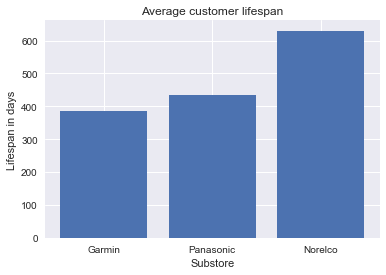

In [15]:
ind = np.arange(3)
plt.bar(ind, total_lifespan)

plt.xlabel("Substore")
plt.title('Average customer lifespan')
plt.ylabel("Lifespan in days")
plt.xticks(ind , num_customers.keys())
plt.show()

In [16]:
for store in stores:
    store['quarter'] = store.date.apply(lambda x: "{}-{}".format(x.year, ((x.month-1)//3)+1))
    store.set_index('id', inplace=True)
    store['CohortGroup'] = store.groupby(level=0)['date'].min().apply(lambda x: "{}-{}".format(x.year, 
                                                                                                ((x.month-1)//3)+1))
    store.reset_index(inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [17]:
garmin.head(5)

,id,date,channel,substore,revenue,profit,quarter,CohortGroup
0,687397,2012-12-25 19:15:07.860,Call Center,Garmin,18.95,9.16,2012-4,2012-4
1,687397,2012-12-17 12:15:51.487,Call Center,Garmin,18.95,11.65,2012-4,2012-4
2,5693517,2011-10-25 15:37:59.933,Call Center,Garmin,299.90,38.05,2011-4,2011-4
3,5693517,2014-03-20 17:01:20.267,Email Marketing,Garmin,6.75,3.75,2014-1,2011-4
4,3827201,2016-06-02 22:21:53.530,Google,Garmin,199.99,17.37,2016-2,2016-2


In [33]:
grouped = [store.groupby(["CohortGroup", 'quarter']) for store in stores]
cohorts = [group.agg({'id': pd.Series.nunique,
                       'date': pd.Series.nunique,
                       'revenue': np.sum,
                       'profit': np.sum}) for group in grouped]
[cohort.rename(columns={'id': 'TotalUsers', 'date':'TotalOrders'}, inplace=True) for cohort in cohorts]
cohorts[0].head(5)

TotalUsers  TotalOrders   revenue   profit
CohortGroup quarter                                            
2009-2      2009-2           69           73  13388.57  3876.14
            2009-3           16           18   2517.36   546.35
            2009-4            6            6   1243.84   254.92
            2010-1            3            3    140.44    43.09
            2010-2            6            6   1806.65   197.45

In [19]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

In [34]:
cohorts = [cohort.groupby(level=0).apply(cohort_period) for cohort in cohorts]
cohorts[0].head()

TotalUsers  TotalOrders   revenue   profit  CohortPeriod
CohortGroup quarter                                                          
2009-2      2009-2           69           73  13388.57  3876.14             1
            2009-3           16           18   2517.36   546.35             2
            2009-4            6            6   1243.84   254.92             3
            2010-1            3            3    140.44    43.09             4
            2010-2            6            6   1806.65   197.45             5

In [35]:
[cohort.reset_index(inplace=True) for cohort in cohorts]
[cohort.set_index(['CohortGroup', 'CohortPeriod'], inplace=True) for cohort in cohorts]

cohort_group_size = [cohort['TotalUsers'].groupby(level=0).first() for cohort in cohorts]
cohort_group_size[0].head()

CohortGroup
2009-2      69
2009-3    1113
2009-4     967
2010-1    1181
2010-2    1859
Name: TotalUsers, dtype: int64

In [39]:
user_retention = [cohorts[i]['TotalUsers'].unstack(0).divide(cohort_group_size[i], axis=1) for i in range(3)]

user_retention[0].head(10)

CohortGroup,2009-2,2009-3,2009-4,2010-1,2010-2,2010-3,2010-4,2011-1,2011-2,2011-3,...,2015-2,2015-3,2015-4,2016-1,2016-2,2016-3,2016-4,2017-1,2017-2,2017-3
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.231884,0.080863,0.061013,0.113463,0.119419,0.143594,0.104970,0.127133,0.148520,0.120638,...,0.187313,0.182609,0.184513,0.213832,0.217514,0.241463,0.230408,0.344168,0.064994,NaN
3,0.086957,0.083558,0.064116,0.095682,0.105433,0.067928,0.066883,0.101816,0.102008,0.109436,...,0.107393,0.083092,0.109498,0.112310,0.119209,0.125610,0.148119,0.015296,NaN,NaN
4,0.043478,0.076370,0.094105,0.093988,0.055406,0.075236,0.089178,0.089158,0.093552,0.096510,...,0.069431,0.092754,0.095584,0.098350,0.091525,0.120122,0.010972,NaN,NaN,NaN
5,0.086957,0.100629,0.098242,0.067739,0.059172,0.082115,0.093358,0.082554,0.087209,0.102973,...,0.085415,0.080193,0.086509,0.084391,0.090960,0.005488,NaN,NaN,NaN,NaN
6,0.057971,0.084456,0.051706,0.063506,0.072620,0.083405,0.069670,0.075399,0.085624,0.058595,...,0.071429,0.071498,0.059286,0.066624,0.007345,NaN,NaN,NaN,NaN,NaN
7,0.043478,0.046721,0.061013,0.071973,0.064551,0.064488,0.078960,0.073748,0.065539,0.047824,...,0.052448,0.046377,0.053237,0.003807,NaN,NaN,NaN,NaN,NaN,NaN
8,0.057971,0.053010,0.049638,0.061812,0.062399,0.065348,0.065490,0.050083,0.045455,0.044377,...,0.043956,0.045894,0.003025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.043478,0.056604,0.070321,0.066892,0.064013,0.060619,0.048769,0.047881,0.037526,0.041361,...,0.049451,0.001932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Garmin Plots

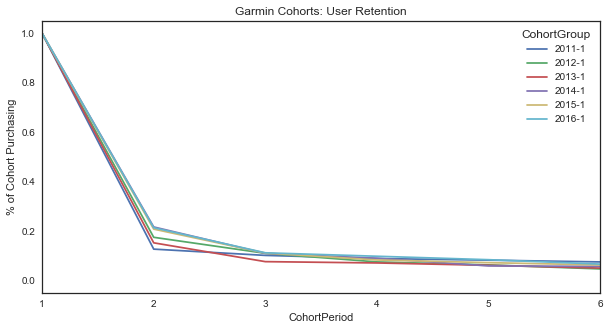

In [40]:
user_retention[0][['2011-1', '2012-1', '2013-1', '2014-1', '2015-1', '2016-1']].plot(figsize=(10,5))
plt.title('Garmin Cohorts: User Retention')
plt.xticks(np.arange(1, 6.1, 1))
plt.xlim(1, 6)
plt.ylabel('% of Cohort Purchasing');

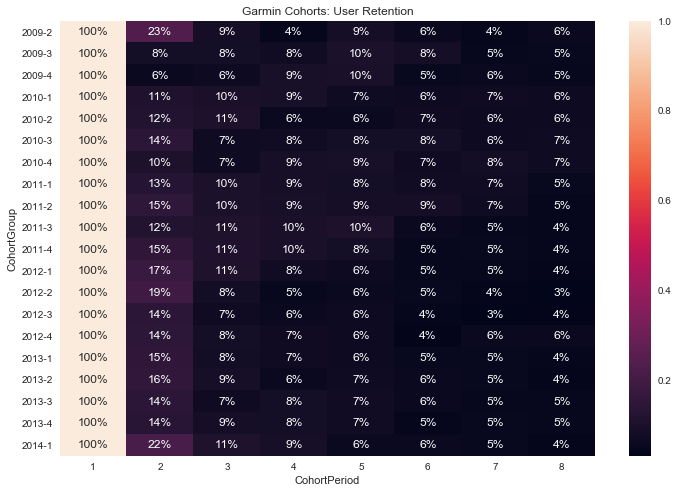

In [41]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Garmin Cohorts: User Retention')
sns.heatmap(user_retention[0].head(8).T.head(20), mask=user_retention[0].head(8).T.head(20).isnull(), annot=True, fmt='.0%');

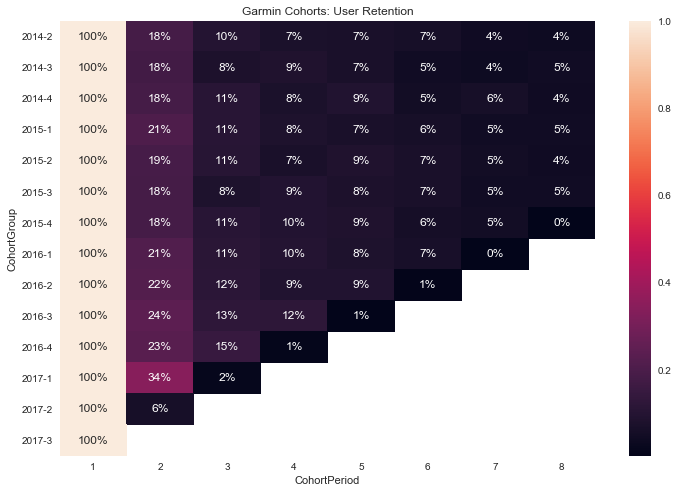

In [50]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Garmin Cohorts: User Retention')
sns.heatmap(user_retention[0].head(8).T.tail(14), mask=user_retention[0].head(8).T.tail(14).isnull(), annot=True, fmt='.0%');

# Panasonic Plots

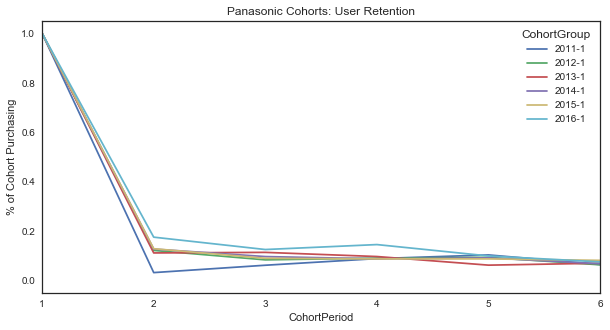

In [43]:
user_retention[1][['2011-1', '2012-1', '2013-1', '2014-1', '2015-1', '2016-1']].plot(figsize=(10,5))
plt.title('Panasonic Cohorts: User Retention')
plt.xticks(np.arange(1, 6.1, 1))
plt.xlim(1, 6)
plt.ylabel('% of Cohort Purchasing');

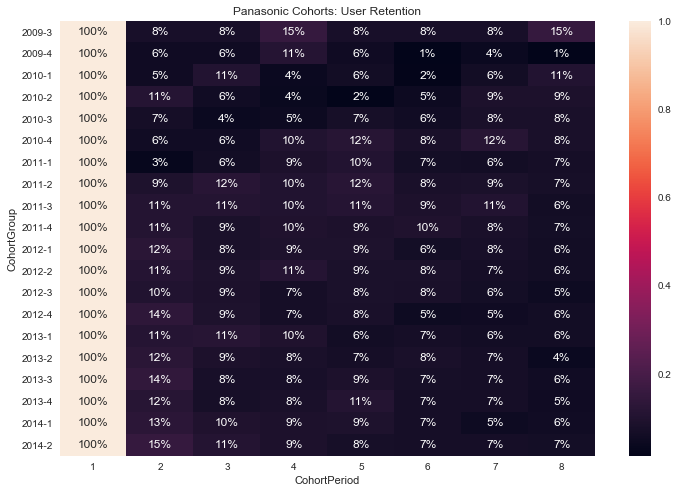

In [49]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Panasonic Cohorts: User Retention')
sns.heatmap(user_retention[1].head(8).T.head(20), mask=user_retention[1].head(8).T.head(20).isnull(), annot=True, fmt='.0%');

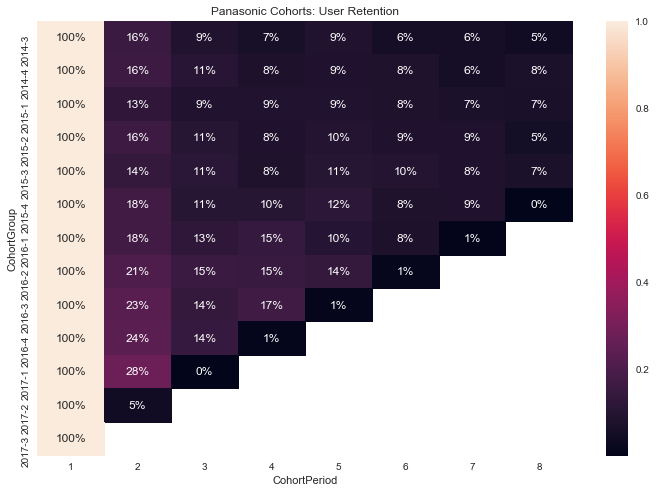

In [56]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Panasonic Cohorts: User Retention')
sns.heatmap(user_retention[1].head(8).T.tail(13), mask=user_retention[1].head(8).T.tail(13).isnull(), annot=True, fmt='.0%');

# Norelco Plots

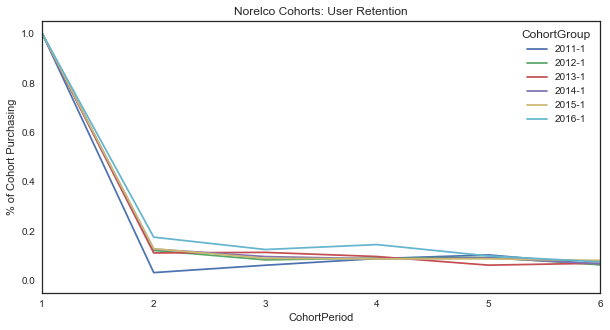

In [45]:
user_retention[1][['2011-1', '2012-1', '2013-1', '2014-1', '2015-1', '2016-1']].plot(figsize=(10,5))
plt.title('Norelco Cohorts: User Retention')
plt.xticks(np.arange(1, 6.1, 1))
plt.xlim(1, 6)
plt.ylabel('% of Cohort Purchasing');

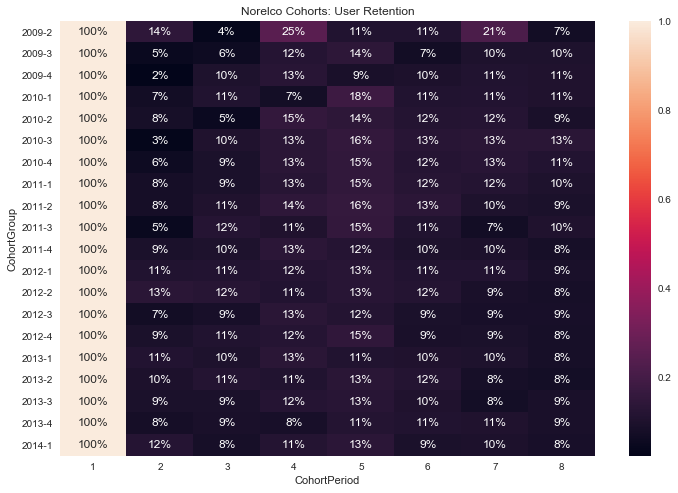

In [46]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Norelco Cohorts: User Retention')
sns.heatmap(user_retention[2].head(8).T.head(20), mask=user_retention[2].head(8).T.head(20).isnull(), annot=True, fmt='.0%');

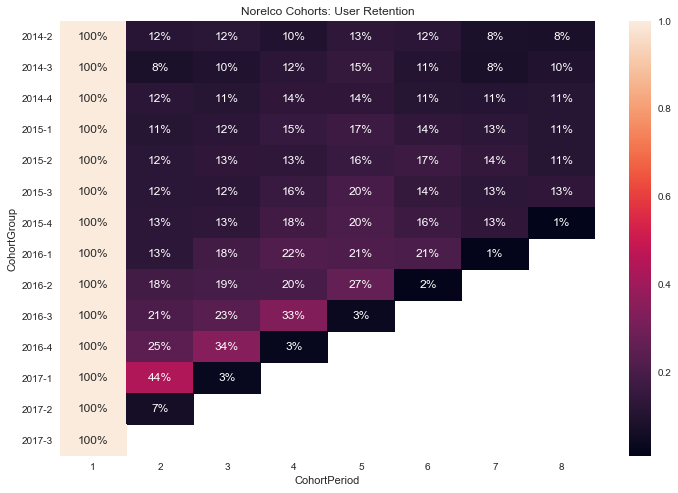

In [57]:
sns.set(style='white')

plt.figure(figsize=(12, 8))
plt.title('Norelco Cohorts: User Retention')
sns.heatmap(user_retention[2].head(8).T.tail(14), mask=user_retention[2].head(8).T.tail(14).isnull(), annot=True, fmt='.0%');

In [81]:
order_dist = [store.id.value_counts().value_counts() for store in stores]
for i in range(3):
    d = order_dist[i]
    order_dist[i] = [1, d[3]/d[2], d[4]/d[2], sum(d[3:])/d[2]]
order_dist = pd.DataFrame(order_dist, index=['Garmin', 'Panasonic', 'Norelco'], columns=['2', '3', '4', '5+'])
order_dist

,2,3,4,5+
Garmin,1,0.164838,0.041535,0.025445
Panasonic,1,0.159668,0.042529,0.030407
Norelco,1,0.236556,0.084188,0.070387


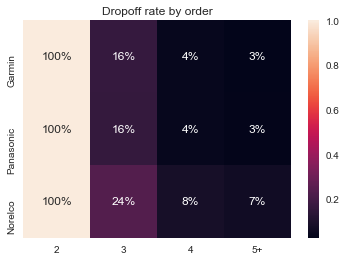

In [82]:
#for index, value in enumerate(['Garmin', 'Panasonic', 'Norelco']):
plt.title("Dropoff rate by order")
sns.heatmap(order_dist, mask=order_dist.isnull(), annot=True, fmt='.0%');

In [47]:
cohorts[0].to_csv('garmin.csv')

In [48]:
cohorts[1].to_csv('panasonic.csv')
cohorts[2].to_csv('norelco.csv')